In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from scipy.signal import find_peaks
from skimage.transform import rotate
import pims, sys
from pathlib import Path
from scipy.signal import savgol_filter
sys.path.insert(0, 'C:\\Warwick\\Code\\')
from Image_Analysis.Filament_Analysis.geometric_2 import SimpleSpline

<blockquote>1. Load the image series, the filament axis (or axes) and visualise.</blockquote>

In [3]:
# Stack and file paths, here we have two stacks that will be combined later.
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\21-02-2023\Untreated_Sample')

filepath_0 = base_path.joinpath(r'Slides\Slide_1\21-Feb-23_TIRF473-6.tif')



# This is to crop the stack, so that we only have the red channel
@pims.pipeline
def crop_image(frame):
    return frame[:,428:]

full_roi_stack_0 = pims.open(filepath_0.as_posix())

# Apply pipeline
images_0 = crop_image(full_roi_stack_0)

#Sometimes the spline goes beyond the image dimensions and causes issues


# Visualise the spline
with plt.style.context('dark_background'):
    fig , ax = plt.subplots(1,1, figsize=(8,5))

    ax.imshow(images_0[610], cmap='inferno')

    ax.set_ylim(500,150)
    ax.set_xlim(0,400)
    
    plt.tight_layout()
    plt.show()

In [4]:
# approach 2
from skimage.filters import threshold_yen
binary = images_0[620] > threshold_yen(images_0[620])

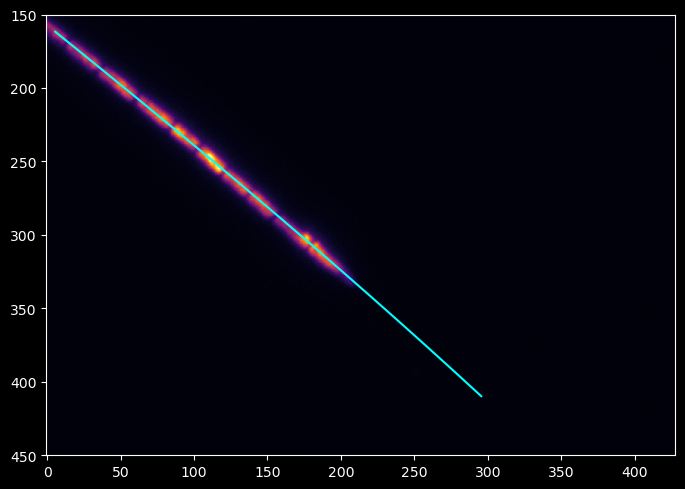

In [9]:
filament_axis = SimpleSpline.from_binary_image(dx=0.01,input_image=binary, spline_k = 3)
filament_axis.crop_to_image_dimensions(images_0[0].shape)
#Sometimes the spline goes beyond the image dimensions and causes issues
filament_axis.crop_to_image_dimensions(images_0[0].shape)


# Visualise the spline
with plt.style.context('dark_background'):
    fig , ax = plt.subplots(1,1, figsize=(8,5))

    ax.imshow(images_0[0], cmap='inferno')
    ax.plot(filament_axis.xy[500:-1000,0], filament_axis.xy[500:-1000:,1], color='cyan')
    ax.set_ylim(450,150)
    plt.tight_layout()
    plt.show()

> 2. Run an intensity profile along the `filament_axis` for the first image. Smooth and find dips corresponding to septae.

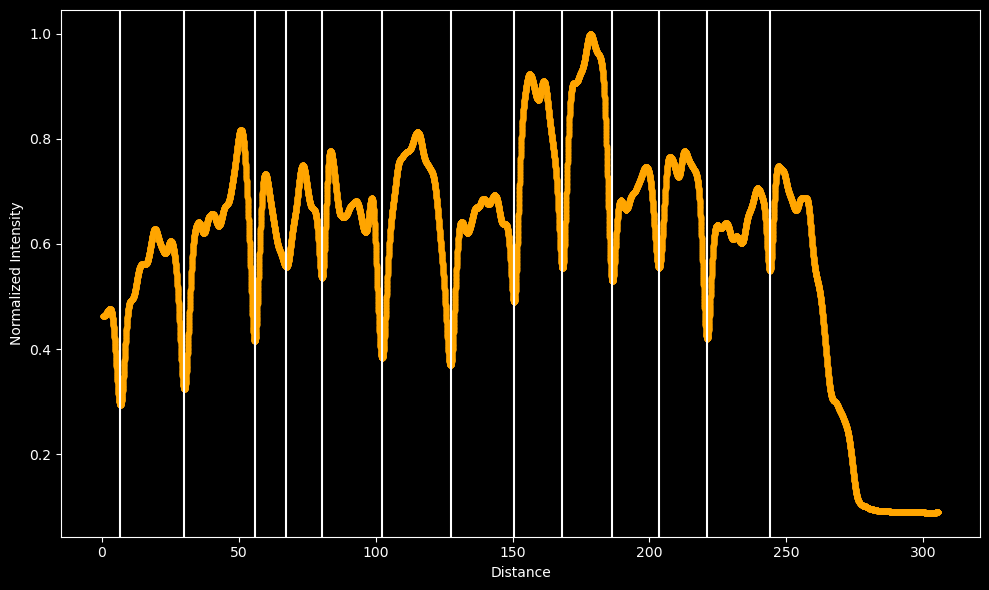

In [33]:
from scipy.interpolate import UnivariateSpline
from skimage.filters import gaussian
from scipy.signal import medfilt
from skimage.filters import median
from scipy.signal import find_peaks_cwt

from scipy.ndimage import map_coordinates

profile = map_coordinates(gaussian(images_0[300]), filament_axis.xy[:, [1, 0]].T)
profile /= np.max(profile)
peaks, *params = find_peaks(-profile, prominence = 0.1, distance=1000)

with plt.style.context('dark_background'):
    fig , ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(filament_axis.xy[:,0], profile,'.', color='orange')

    for peak in peaks:
        ax.axvline(filament_axis.xy[:,0][peak])
    ax.set_ylabel('Normalized Intensity')
    ax.set_xlabel('Distance')
    #ax.axvspan(365,400,color='red', alpha=1)
    #ax.set_xlim(400,500)
    plt.tight_layout()
    plt.show()

In [17]:
peaks

array([], dtype=int64)

> 3. Iterate over the entire image series, save `x` positions of the peaks, their `frame`, and peak prominences as `params`

In [34]:
all_peaks_x = []
all_peaks_frame = []
all_params = []

total_frame_length = len(images_0)

for n in range(total_frame_length):
    if n%200 == 0:
        print(f'processed {n} images')

    image = images_0[n]

    profile = map_coordinates(gaussian(images_0[n]), filament_axis.xy[:, [1, 0]].T)
    profile /= np.max(profile)
    peaks, *params = find_peaks(-profile, prominence = 0.1, distance=1000)
    
    for k,peak in enumerate(peaks):
        all_peaks_x.append(filament_axis.xy[:,0][peak])
        all_peaks_frame.append(n)
        all_params.append(params[0]['prominences'][k])

processed 0 images
processed 200 images
processed 400 images
processed 600 images
processed 800 images
processed 1000 images
processed 1200 images
processed 1400 images
processed 1600 images


> 4. Create a `pandas.DataFrame` containing peaks `x`, `frames`, `prominences` and a dummy value for `y`so that trackpy works to track and link them all

In [35]:
import pandas as pd
import trackpy as tp

data = [all_peaks_frame, all_peaks_x, [1]*len(all_peaks_x), all_params]
septae_dataframe = pd.DataFrame(list(zip(*data)), columns=['frame', 'x', 'y', 'params'])

# Filter out some low prominence values if needed
#prominence_filtered = septae_dataframe[septae_dataframe['prominence'] >=0.15]

# Link and remove short trajectories
linked = tp.link(septae_dataframe,5, memory=2)
linked_filtered = tp.filter_stubs(linked, 400)

Frame 1765: 1 trajectories present.


In [34]:
# partial save in this dir
#septae_dataframe.to_csv('septae_dataframe_29_06_23_not_lat_int.csv')

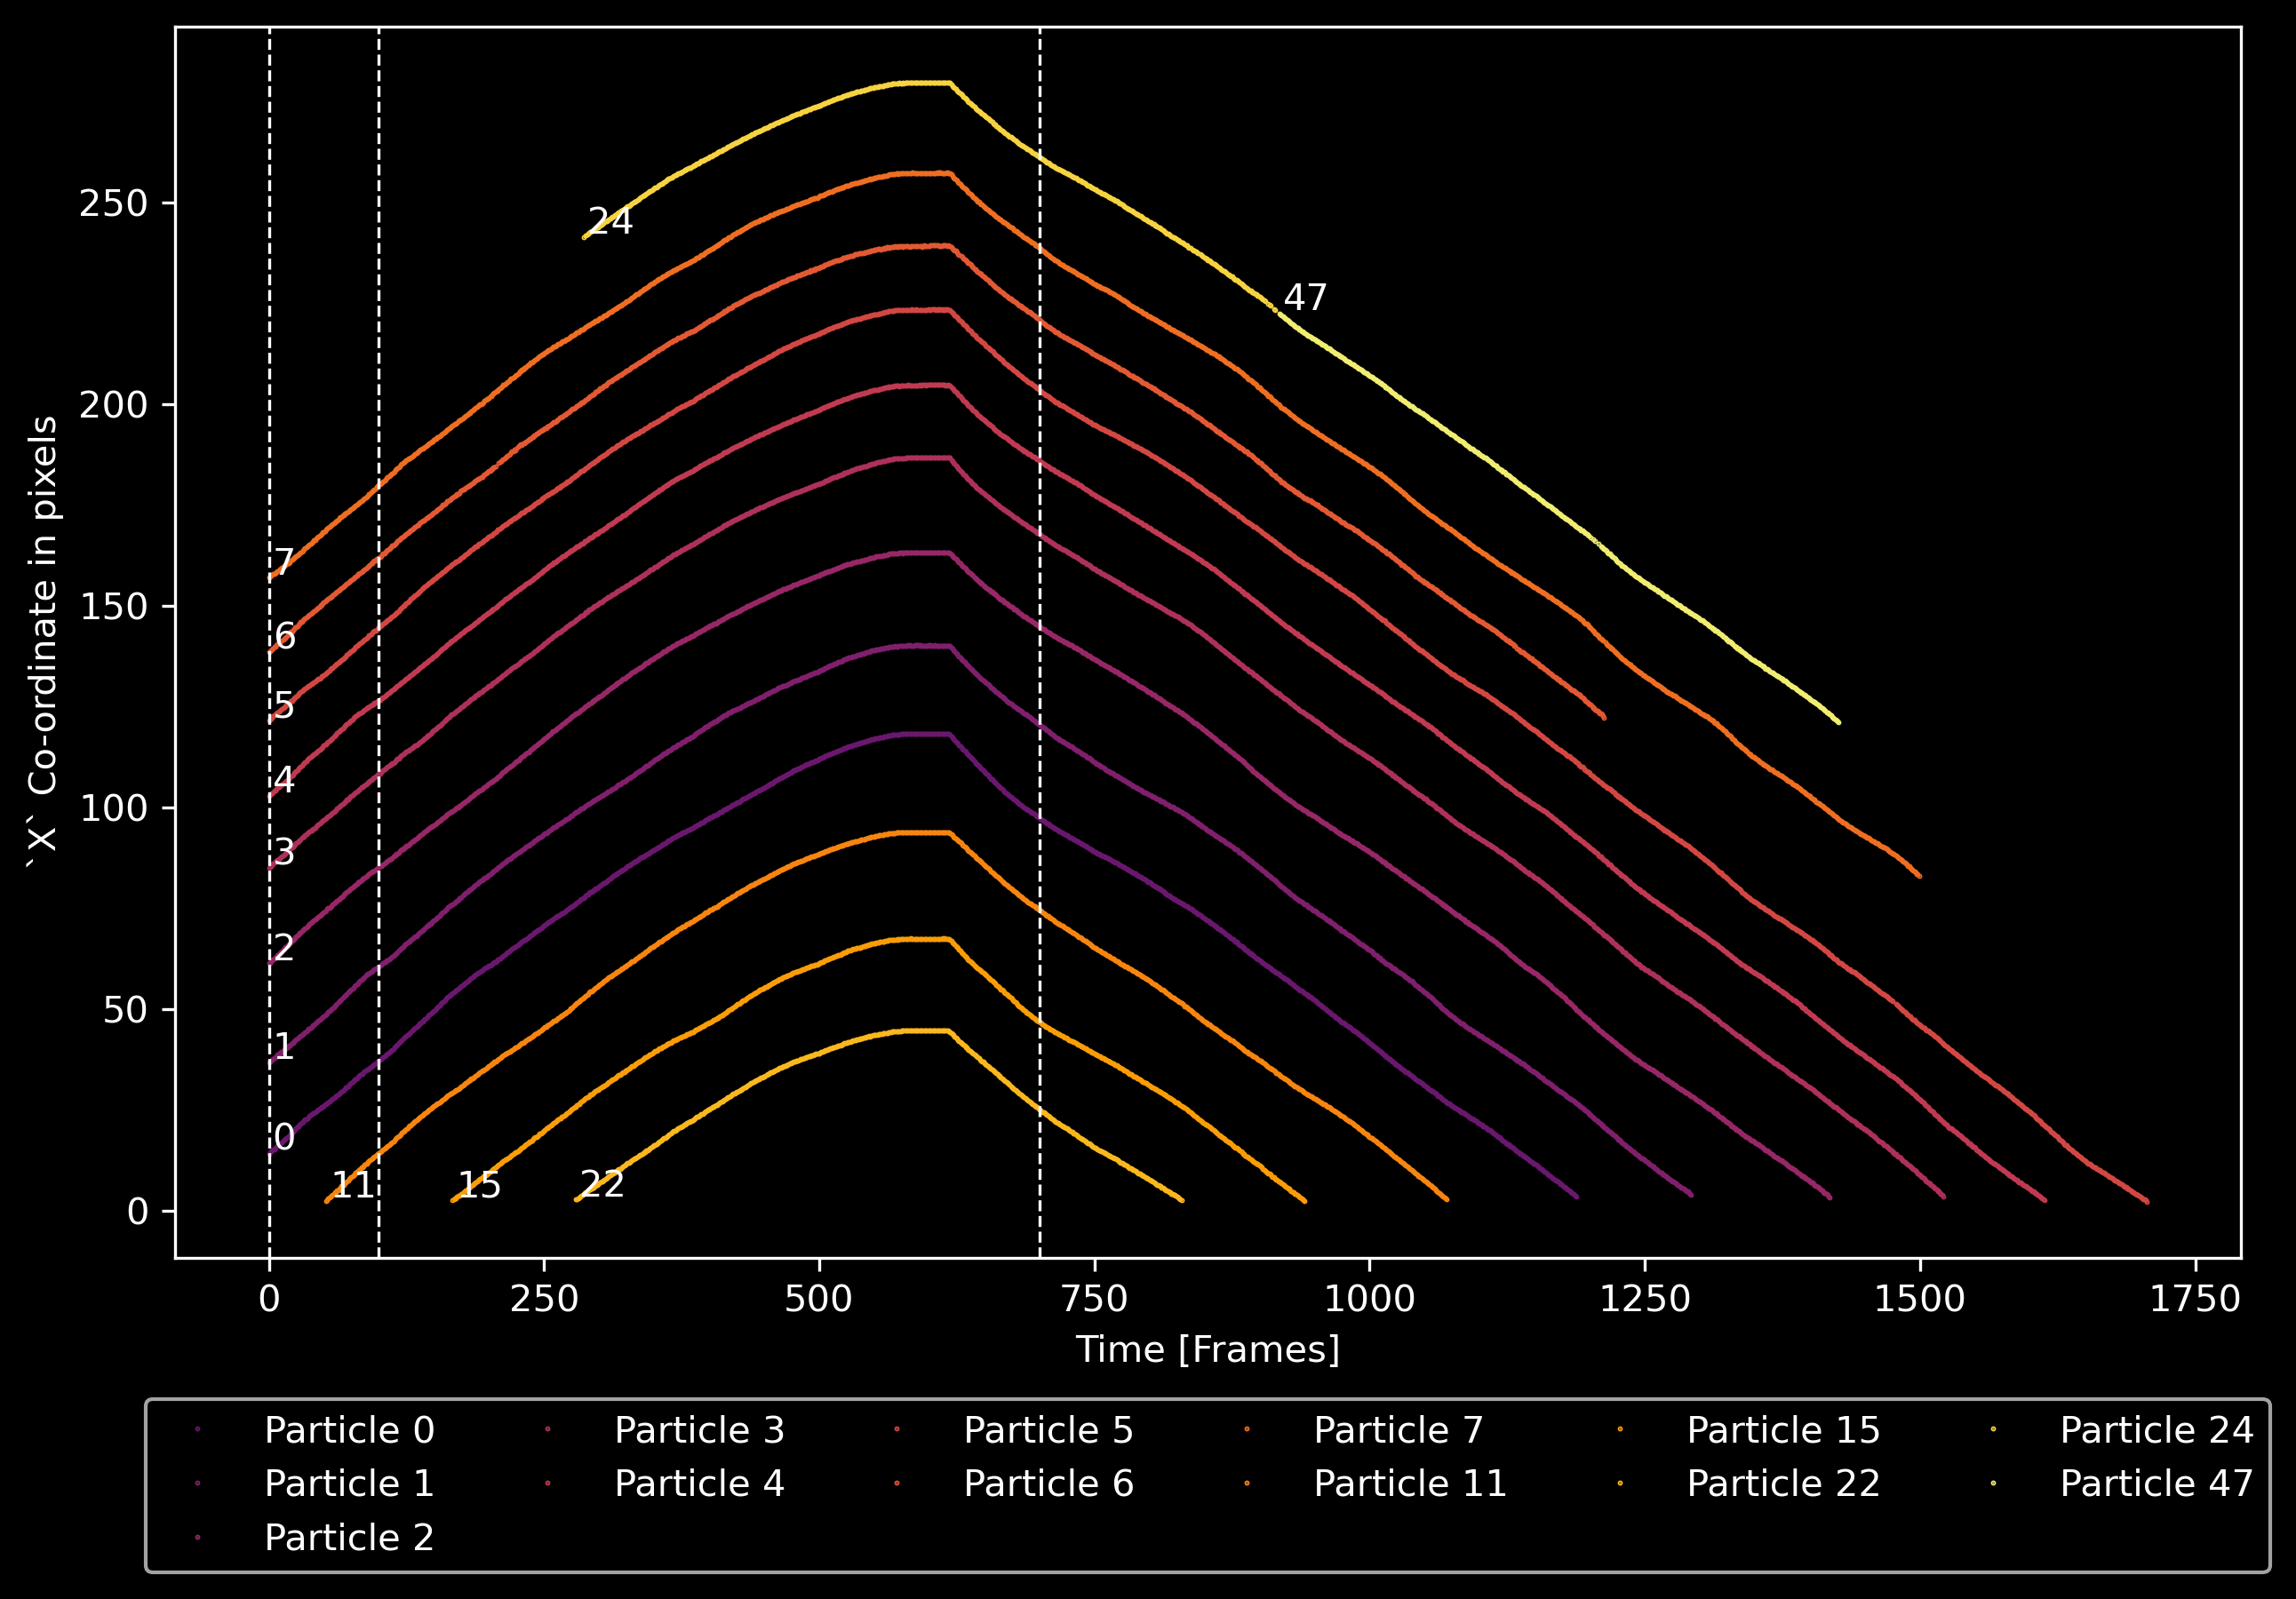

In [36]:
unique_particles = pd.unique(linked_filtered['particle'])

colors = plt.cm.inferno(np.linspace(0.3,1,len(unique_particles)+1))

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (10,6), dpi=300)

    for n,x in enumerate(unique_particles):
        time_axis = linked_filtered.loc[linked_filtered['particle'] == x]['frame'].values
        pos_axis = linked_filtered.loc[linked_filtered['particle'] == x]['x'].values
        ax.plot(time_axis, pos_axis,'.', markersize=0.8, color = colors[n], label = f'Particle {x}')
        ax.annotate(f'{x}', xy=(time_axis[0], pos_axis[0]), xytext=(1, 1),
            textcoords='offset points')
    
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)

    # Guidelines if needed
    ax.axvline(100, linestyle='--', linewidth=0.8)
    ax.axvline(0, linestyle='--', linewidth=0.8)
    ax.axvline(700, linestyle='--', linewidth=0.8)
    #ax.set_xlim(0,100)
    ax.set_ylabel('`X` Co-ordinate in pixels')
    ax.set_xlabel('Time [Frames]')
    plt.show()

In [102]:
linked_refiltered = linked_filtered[(linked_filtered['particle'].isin([0,3,7]))]
#linked_refiltered = linked_filtered.copy()

In [80]:
#linked_filtered.loc[linked_filtered['particle'] == 36, 'particle'] = 1

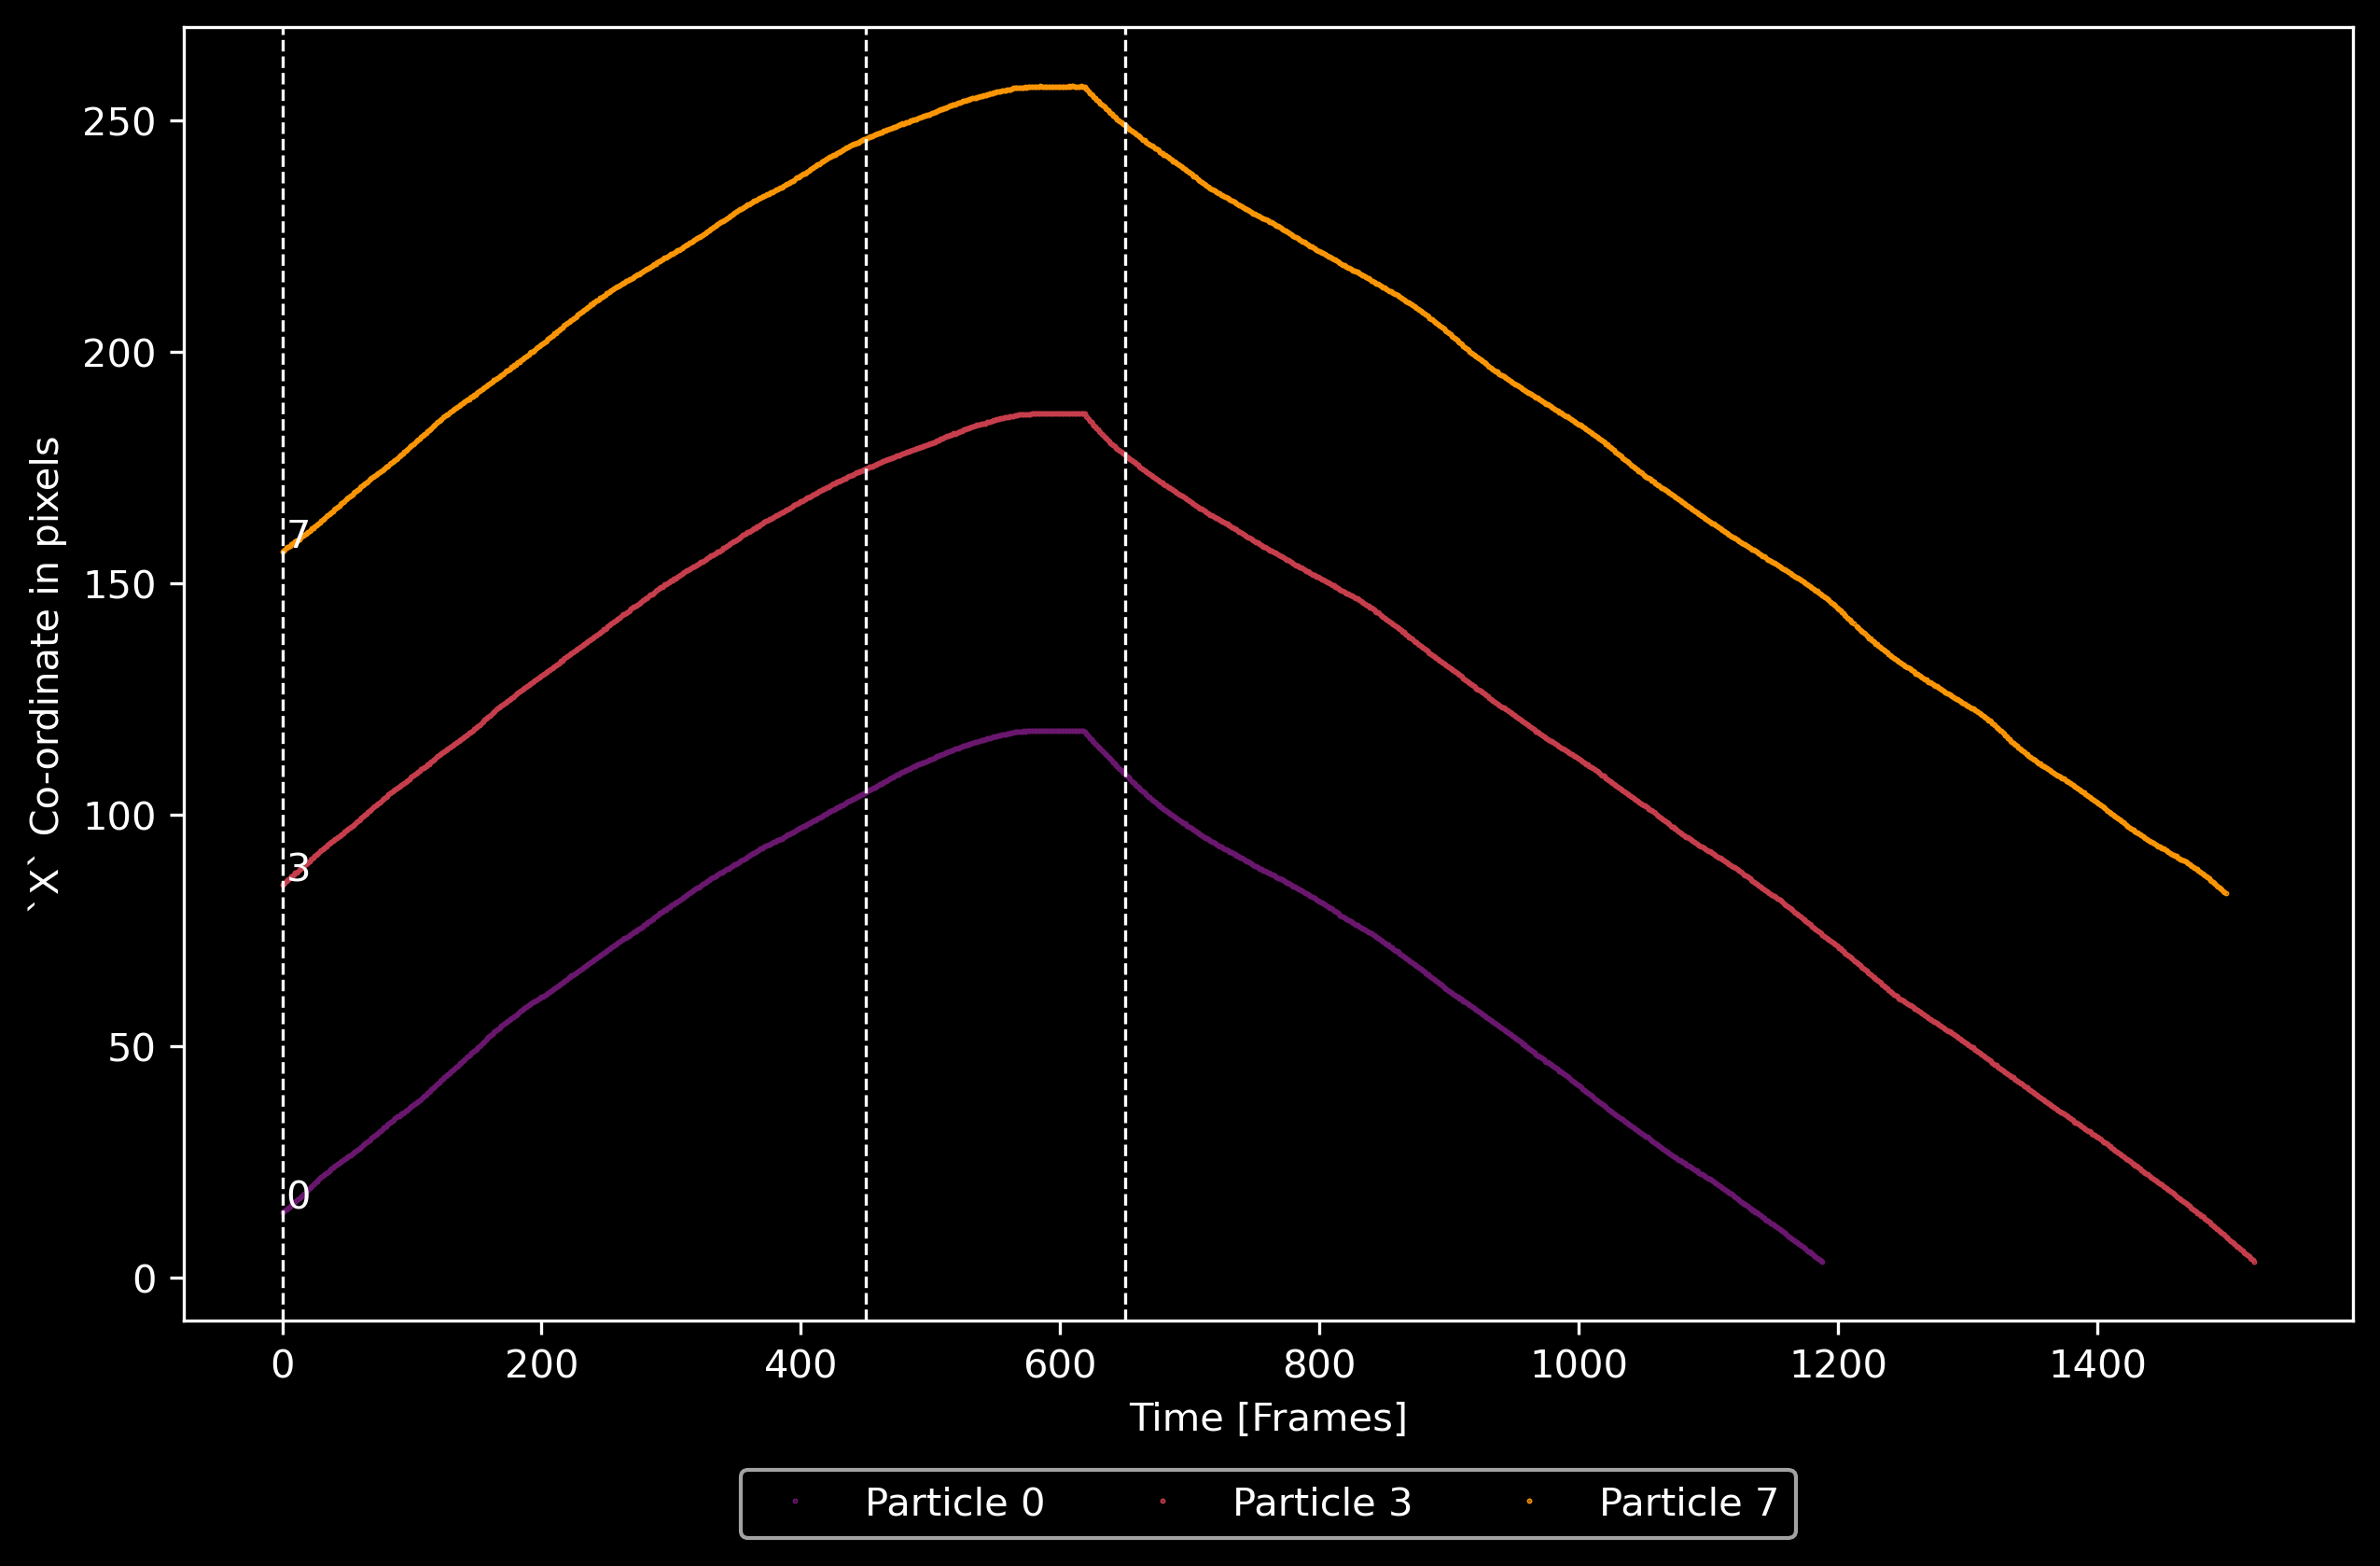

In [103]:
unique_particles = pd.unique(linked_refiltered['particle'])

colors = plt.cm.inferno(np.linspace(0.3,1,len(unique_particles)+1))

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (10,6), dpi=300)

    for n,x in enumerate(unique_particles):
        time_axis = linked_refiltered.loc[linked_refiltered['particle'] == x]['frame'].values
        pos_axis = linked_refiltered.loc[linked_refiltered['particle'] == x]['x'].values
        ax.plot(time_axis, pos_axis,'.', markersize=0.8, color = colors[n], label = f'Particle {x}')
        ax.annotate(f'{x}', xy=(time_axis[0], pos_axis[0]), xytext=(1, 1),
            textcoords='offset points')
    
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)

    # Guidelines if needed
    ax.axvline(450, linestyle='--', linewidth=0.8)
    ax.axvline(0, linestyle='--', linewidth=0.8)
    ax.axvline(650, linestyle='--', linewidth=0.8)
    #ax.set_xlim(200,500)
    ax.set_ylabel('`X` Co-ordinate in pixels')
    ax.set_xlabel('Time [Frames]')
    plt.show()

In [126]:
# Filter
linked_refiltered_2 = linked_refiltered[((linked_refiltered['frame'] >= 0) &
                                         (linked_refiltered['frame'] <= 1100)) ].copy()

In [127]:
unique_particles = pd.unique(linked_refiltered_2['particle'])

colors = plt.cm.inferno(np.linspace(0.3,1,np.max(unique_particles)+1))

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (10,6), dpi=300)

    for n,x in enumerate(unique_particles):
        time_axis = linked_refiltered_2.loc[linked_refiltered_2['particle'] == x]['frame'].values
        pos_axis = linked_refiltered_2.loc[linked_refiltered_2['particle'] == x]['x'].values
        ax.plot(time_axis, pos_axis,'.', markersize=0.8, color = colors[x], label = f'Particle {x}')
        ax.annotate(f'{x}', xy=(time_axis[0], pos_axis[0]), xytext=(1, 1),
            textcoords='offset points')
    
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)

    # Guidelines if needed
    ax.axvline(450, linestyle='--', linewidth=0.8)
    ax.axvline(0, linestyle='--', linewidth=0.8)
    ax.axvline(830, linestyle='--', linewidth=0.8)
    #ax.set_xlim(200,500)
    ax.set_ylabel('`X` Co-ordinate in pixels')
    ax.set_xlabel('Time [Frames]')
    plt.show()

In [128]:
# Convert to distance

linked_refiltered_2.loc[:,'distances'] = filament_axis.x_values_to_distances(linked_refiltered_2['x'].values)


In [129]:
#Sorting

# Step 1: Calculate the mean 'distance' between frames 0 and 5 for each group
def min_dist(group):
    return group.loc[group['frame'].between(450, 455), 'distances'].mean()

mean_distances = linked_refiltered_2.groupby(['particle']).apply(min_dist).reset_index()

mean_distances.columns = ['particle', 'mean_distance']

# Step 2: Rank the 'particle_sorted' values based on the mean 'distance' for each 'experiment' group
mean_distances['particle_sorted'] = mean_distances['mean_distance'].rank(method='min').astype(int) - 1



# Merge the 'particle' column back to the original DataFrame
linked_refiltered_2 = pd.merge(linked_refiltered_2, mean_distances[['particle', 'particle_sorted']], on=['particle'])

In [130]:
unique_particles = pd.unique(linked_refiltered_2['particle_sorted'])

colors = plt.cm.inferno(np.linspace(0.3,1,max(unique_particles)+1))

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (10,6), dpi=300)

    for n,x in enumerate(unique_particles):
        time_axis = linked_refiltered_2.loc[linked_refiltered_2['particle_sorted'] == x]['frame'].values
        pos_axis = linked_refiltered_2.loc[linked_refiltered_2['particle_sorted'] == x]['distances'].values
        ax.plot(time_axis, pos_axis,'.', markersize=0.8, color = colors[x], label = f'Particle {x}')
        ax.annotate(f'{x}', xy=(time_axis[0], pos_axis[0]), xytext=(1, 1),
            textcoords='offset points')
    
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)

    # Guidelines if needed
    ax.axvline(450, linestyle='--', linewidth=0.8)
    ax.axvline(0, linestyle='--', linewidth=0.8)
    ax.axvline(830, linestyle='--', linewidth=0.8)
    #ax.set_xlim(200,500)
    ax.set_ylabel('`X` Co-ordinate in pixels')
    ax.set_xlabel('Time [Frames]')
    plt.show()

In [144]:
unique_particles

array([0, 1, 2])

In [132]:
linked_refiltered_2.index.names = ['']
linked_refiltered_2.reset_index(inplace=True)
linked_refiltered_2.drop(columns=[''], inplace=True)
linked_refiltered_2.head()

frame      x  y    params  particle  distances  particle_sorted
0      0  14.12  1  0.200177         0  17.495364                0
1      1  14.37  1  0.201677         0  17.816739                0
2      2  14.62  1  0.192712         0  18.138122                0
3      3  14.84  1  0.209252         0  18.420946                0
4      4  15.02  1  0.199613         0  18.652353                0

In [133]:
def rel_distance(group):
    sorted_group = group.sort_values('frame')
    initial_distance = sorted_group.iloc[:10]['distances'].mean()
    group['rel_distance'] = group['distances'] - initial_distance
    return group

linked_refiltered_2 = linked_refiltered_2.groupby('particle').apply(rel_distance)

In [134]:
linked_refiltered_2

frame       x  y    params  particle   distances  particle_sorted  \
0         0   14.12  1  0.200177         0   17.495364                0   
1         1   14.37  1  0.201677         0   17.816739                0   
2         2   14.62  1  0.192712         0   18.138122                0   
3         3   14.84  1  0.209252         0   18.420946                0   
4         4   15.02  1  0.199613         0   18.652353                0   
...     ...     ... ..       ...       ...         ...              ...   
3298   1096  164.29  1  0.479396         7  212.632763                2   
3299   1097  164.08  1  0.472742         7  212.356252                2   
3300   1098  163.94  1  0.478984         7  212.171918                2   
3301   1099  163.74  1  0.491958         7  211.908593                2   
3302   1100  163.57  1  0.499631         7  211.684775                2   

      rel_distance  
0        -1.357579  
1        -1.036205  
2        -0.714822  
3        -0.431997  
4        -0.200590  
...            ...  
3298      8.470189  
3299      8.193678  
3300      8.009344  
3301      7.746019  
3302      7.522201  

[3303 rows x 8 columns]

In [135]:
unique_particles

array([0, 1, 2])

In [145]:
unique_particles = pd.unique(linked_refiltered_2['particle_sorted'])

colors = plt.cm.inferno(np.linspace(0.3,1,max(unique_particles)+1))

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (10,6), dpi=300)

    for n,x in enumerate(unique_particles):
        time_axis = linked_refiltered_2.loc[linked_refiltered_2['particle_sorted'] == x]['frame'].values
        pos_axis = linked_refiltered_2.loc[linked_refiltered_2['particle_sorted'] == x]['rel_distance'].values
        ax.plot(time_axis, pos_axis,'-', markersize=0.8, color = colors[x], label = f'Particle {x}')
        ax.annotate(f'{x}', xy=(time_axis[0], pos_axis[0]), xytext=(1, 1),
            textcoords='offset points')
    
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)

    # Guidelines if needed
    ax.axvline(450, linestyle='--', linewidth=0.8)
    #ax.axvline(0, linestyle='--', linewidth=0.8)
    #ax.axvline(830, linestyle='--', linewidth=0.8)
    ax.set_xlim(400,800)
    ax.set_ylim(125,135)
    ax.set_ylabel('`X` Co-ordinate in pixels')
    ax.set_xlabel('Time [Frames]')
    plt.show()

array([108.9022026 , 109.22664009, 109.55109033, ..., 118.84882023,
       118.62794018, 118.31611987])

In [158]:
plt.plot(0.112*(linked_refiltered_2[linked_refiltered_2['particle_sorted'] == 1]['distances'].values -
         linked_refiltered_2[linked_refiltered_2['particle_sorted'] == 0]['distances'].values),
         '.')

plt.plot(0.112*(linked_refiltered_2[linked_refiltered_2['particle_sorted'] == 2]['distances'].values -
         linked_refiltered_2[linked_refiltered_2['particle_sorted'] == 1]['distances'].values),
         '.')